# Data retrieval

In [1]:
!wget https://datasets.imdbws.com/title.episode.tsv.gz

--2025-03-24 14:23:32--  https://datasets.imdbws.com/title.episode.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 18.238.49.75, 18.238.49.94, 18.238.49.13, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|18.238.49.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48935156 (47M) [binary/octet-stream]
Saving to: ‘title.episode.tsv.gz’

title.episode.tsv.g 100%[===================>]  46.67M  96.8MB/s    in 0.5s    

2025-03-24 14:23:33 (96.8 MB/s) - ‘title.episode.tsv.gz’ saved [48935156/48935156]



In [2]:
!gunzip title.episode.tsv.gz

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, countDistinct, isnan, when
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import desc
import pandas as pd

In [4]:
spark = SparkSession.builder.getOrCreate()

In [5]:
df = spark.read.csv("/content/title.episode.tsv", sep="\t", header=True, inferSchema=True)
df.show()


+---------+------------+------------+-------------+
|   tconst|parentTconst|seasonNumber|episodeNumber|
+---------+------------+------------+-------------+
|tt0031458|  tt32857063|          \N|           \N|
|tt0041951|   tt0041038|           1|            9|
|tt0042816|   tt0989125|           1|           17|
|tt0042889|   tt0989125|          \N|           \N|
|tt0043426|   tt0040051|           3|           42|
|tt0043631|   tt0989125|           2|           16|
|tt0043693|   tt0989125|           2|            8|
|tt0043710|   tt0989125|           3|            3|
|tt0044093|   tt0959862|           1|            6|
|tt0044668|   tt0044243|           2|           16|
|tt0044901|   tt0989125|           3|           46|
|tt0045519|   tt0989125|           4|           11|
|tt0045960|   tt0044284|           2|            3|
|tt0046135|   tt0989125|           4|            5|
|tt0046150|   tt0341798|          \N|           \N|
|tt0046855|   tt0046643|           1|            4|
|tt0046864| 

# Data preliminary analysis

In [6]:
df.dtypes

[('tconst', 'string'),
 ('parentTconst', 'string'),
 ('seasonNumber', 'string'),
 ('episodeNumber', 'string')]

In [7]:
df.describe()

DataFrame[summary: string, tconst: string, parentTconst: string, seasonNumber: string, episodeNumber: string]

## Handle null values

In [8]:
df = df.replace("\\N", None)

## Total number of values

In [9]:
from pyspark.sql import functions as F

total_rows = df.count()
print("Total rows in dataset: ", total_rows)

Total rows in dataset:  8878746


## count of null/"NaN"/"\\N" values

In [10]:
from pyspark.sql import functions as F

# Function to count null, "\N", or "NaN" values for each column
null_or_N_or_NaN_counts = {
    col: df.filter(F.col(col).isNull() |
                   (F.col(col) == r"\N") |
                   (F.col(col) == "NaN")).count()
    for col in df.columns
}

# Print counts of null, "\N", or "NaN" values for each column
for column, count in null_or_N_or_NaN_counts.items():
    print(f"Column '{column}' has {count} null, '\\N', or 'NaN' values.")


Column 'tconst' has 0 null, '\N', or 'NaN' values.
Column 'parentTconst' has 0 null, '\N', or 'NaN' values.
Column 'seasonNumber' has 1812669 null, '\N', or 'NaN' values.
Column 'episodeNumber' has 1812669 null, '\N', or 'NaN' values.


In [11]:
for column in df.columns:
    unique_count = df.select(column).distinct().count()
    print(f"Column '{column}' has {unique_count} unique values.")

Column 'tconst' has 8878746 unique values.
Column 'parentTconst' has 217918 unique values.
Column 'seasonNumber' has 320 unique values.
Column 'episodeNumber' has 15785 unique values.


## Stats of dataframe.
### contains:
- column name;
- number of null values;
- number of unique values;
- total number of values;
- percentage of null values per column;
- data type;
- example value.

In [12]:
from pyspark.sql.functions import col, sum, countDistinct, first

def data_stats(df):
    total_rows = df.count()

    # Compute null values count
    null_counts = df.select([
        sum(col(c).isNull().cast("integer")).alias(c) for c in df.columns
    ]).toPandas().T.reset_index()
    null_counts.columns = ["Column", "Null Values"]

    # Compute unique values count
    unique_counts = df.select([
        countDistinct(col(c)).alias(c) for c in df.columns
    ]).toPandas().T.reset_index()
    unique_counts.columns = ["Column", "Unique Values"]

    # Get data types
    data_types = {c: str(df.schema[c].dataType) for c in df.columns}

    # Get an example value for each column
    example_row = df.select([first(col(c), ignorenulls=True).alias(c) for c in df.columns]).collect()[0]
    example_values = {c: example_row[c] if example_row[c] is not None else "N/A" for c in df.columns}

    # Merge all stats into a DataFrame
    stats_df = null_counts.merge(unique_counts, on="Column", how="left")
    stats_df["Total Values"] = total_rows
    stats_df["Null Percentage"] = (stats_df["Null Values"] / total_rows) * 100
    stats_df["Data Type"] = stats_df["Column"].map(data_types)
    stats_df["Example Value"] = stats_df["Column"].map(example_values)

    return stats_df

# Run function and display results
stats = data_stats(df)

In [13]:
stats

,Column,Null Values,Unique Values,Total Values,Null Percentage,Data Type,Example Value
0,tconst,0,8878746,8878746,0.000000,StringType(),tt0031458
1,parentTconst,0,217918,8878746,0.000000,StringType(),tt32857063
2,seasonNumber,1812669,319,8878746,20.415822,StringType(),1
3,episodeNumber,1812669,15784,8878746,20.415822,StringType(),9


## Check for "NaN" values

In [14]:
from pyspark.sql.functions import col, sum, isnan

def nan_value_stats(df):
    nan_counts = df.select([
        sum(when(isnan(col(c)), 1).otherwise(0)).alias(c) if dict(df.dtypes)[c] in ["double", "float", "int"]
        else sum(when(col(c) == "NaN", 1).otherwise(0)).alias(c)
        for c in df.columns
    ]).toPandas().T.reset_index()

    nan_counts.columns = ["Column", "NaN Values"]
    return nan_counts

# Run function and display results
nan_stats = nan_value_stats(df)
print(nan_stats)


          Column  NaN Values
0         tconst           0
1   parentTconst           0
2   seasonNumber           0
3  episodeNumber           0


## Count of null values per each column

In [15]:
from pyspark.sql.functions import col, sum

def null_value_stats(df):
    null_counts = df.select([
        sum(col(c).isNull().cast("integer")).alias(c) for c in df.columns
    ]).toPandas().T.reset_index()

    null_counts.columns = ["Column", "Null Values"]
    return null_counts


null_stats = null_value_stats(df)
print(null_stats)


          Column  Null Values
0         tconst            0
1   parentTconst            0
2   seasonNumber      1812669
3  episodeNumber      1812669


## Cast "seasonNumber" and "episodeNumber" columns into integer.


In [16]:
from pyspark.sql import functions as F

df = df.withColumn("seasonNumber", df["seasonNumber"].cast("int"))
df = df.withColumn("episodeNumber", df["episodeNumber"].cast("int"))

In [17]:
df.dtypes

[('tconst', 'string'),
 ('parentTconst', 'string'),
 ('seasonNumber', 'int'),
 ('episodeNumber', 'int')]

# Check for duplicates in data:

In [18]:
total_rows = df.count()
unique_rows = df.dropDuplicates().count()
duplicates_count = total_rows - unique_rows

print(f"Number of duplicate rows: {duplicates_count}")


Number of duplicate rows: 0


 # Check for null values.

 (There is a suspicion, that if there is a null value in a <code>seasonNumber</code> column, then the value in <code>episodeNumber</code> is also null; <br>
 If true, than such rows can be dropped.)

In [19]:
df.filter((F.col("seasonNumber").isNull()) & (F.col("episodeNumber").isNotNull())).show()

+------+------------+------------+-------------+
|tconst|parentTconst|seasonNumber|episodeNumber|
+------+------------+------------+-------------+
+------+------------+------------+-------------+



In [20]:
df.filter((F.col("episodeNumber").isNull()) & (F.col("seasonNumber").isNotNull())).show()

+------+------------+------------+-------------+
|tconst|parentTconst|seasonNumber|episodeNumber|
+------+------------+------------+-------------+
+------+------------+------------+-------------+



In [21]:
df = df.dropna()

## Stats after data cleaning

In [22]:
stats = data_stats(df)
stats

,Column,Null Values,Unique Values,Total Values,Null Percentage,Data Type,Example Value
0,tconst,0,7066077,7066077,0.0,StringType(),tt0041951
1,parentTconst,0,194032,7066077,0.0,StringType(),tt0041038
2,seasonNumber,0,319,7066077,0.0,IntegerType(),1
3,episodeNumber,0,15784,7066077,0.0,IntegerType(),9


In [23]:
df.show()

+---------+------------+------------+-------------+
|   tconst|parentTconst|seasonNumber|episodeNumber|
+---------+------------+------------+-------------+
|tt0041951|   tt0041038|           1|            9|
|tt0042816|   tt0989125|           1|           17|
|tt0043426|   tt0040051|           3|           42|
|tt0043631|   tt0989125|           2|           16|
|tt0043693|   tt0989125|           2|            8|
|tt0043710|   tt0989125|           3|            3|
|tt0044093|   tt0959862|           1|            6|
|tt0044668|   tt0044243|           2|           16|
|tt0044901|   tt0989125|           3|           46|
|tt0045519|   tt0989125|           4|           11|
|tt0045960|   tt0044284|           2|            3|
|tt0046135|   tt0989125|           4|            5|
|tt0046855|   tt0046643|           1|            4|
|tt0046864|   tt0989125|           5|           20|
|tt0047810|   tt0914702|           3|           36|
|tt0047852|   tt0047745|           1|           15|
|tt0047858| 

## Data integrity check

Number of distinct values in column <code>seasonNumber</code> seems too high.

### Insight of <code>seasonNumber</code>.

In [24]:
df.filter(df['seasonNumber'] == 250).show()

+----------+------------+------------+-------------+
|    tconst|parentTconst|seasonNumber|episodeNumber|
+----------+------------+------------+-------------+
|tt32489279|   tt0369117|         250|            1|
|tt32489303|   tt0369117|         250|            2|
|tt32524518|   tt0369117|         250|            3|
|tt32524530|   tt0369117|         250|           13|
|tt32590572|   tt0369117|         250|            4|
|tt32591613|   tt0369117|         250|            6|
|tt32592444|   tt0369117|         250|            9|
|tt32641480|   tt0369117|         250|           10|
|tt32758250|   tt0369117|         250|           12|
|tt32758277|   tt0369117|         250|            8|
|tt32809579|   tt0369117|         250|            5|
|tt32809583|   tt0369117|         250|           11|
|tt32868281|   tt0369117|         250|            7|
+----------+------------+------------+-------------+



In [25]:
df.select("seasonNumber").distinct().orderBy("seasonNumber", ascending=True).show(320)

+------------+
|seasonNumber|
+------------+
|           1|
|           2|
|           3|
|           4|
|           5|
|           6|
|           7|
|           8|
|           9|
|          10|
|          11|
|          12|
|          13|
|          14|
|          15|
|          16|
|          17|
|          18|
|          19|
|          20|
|          21|
|          22|
|          23|
|          24|
|          25|
|          26|
|          27|
|          28|
|          29|
|          30|
|          31|
|          32|
|          33|
|          34|
|          35|
|          36|
|          37|
|          38|
|          39|
|          40|
|          41|
|          42|
|          43|
|          44|
|          45|
|          46|
|          47|
|          48|
|          49|
|          50|
|          51|
|          52|
|          53|
|          54|
|          55|
|          56|
|          57|
|          58|
|          59|
|          60|
|          61|
|          62|
|          63|
|         

We can see that in ascending order, there are values like <code>1965, 1966</code>, etc., that look like invalid. The largest value that goes correctly in ascending order is 259.
(This looks like it is correct: according to the internet resources there is such TV series called <code>House Hunters</code>, that has 262 seasons.)

### Insight of <code>episodeNumber</code>

In [26]:
df.select("episodeNumber").distinct().orderBy("episodeNumber", ascending=False).show(320)

+-------------+
|episodeNumber|
+-------------+
|        91334|
|        80207|
|        79800|
|        77305|
|        72615|
|        48505|
|        48504|
|        48503|
|        48502|
|        48501|
|        46002|
|        40000|
|        28422|
|        25000|
|        21907|
|        20910|
|        20008|
|        19805|
|        18402|
|        18081|
|        18000|
|        15762|
|        15761|
|        15760|
|        15759|
|        15758|
|        15757|
|        15756|
|        15755|
|        15754|
|        15753|
|        15752|
|        15751|
|        15750|
|        15749|
|        15748|
|        15747|
|        15746|
|        15745|
|        15744|
|        15743|
|        15742|
|        15741|
|        15740|
|        15739|
|        15738|
|        15737|
|        15736|
|        15735|
|        15734|
|        15733|
|        15732|
|        15731|
|        15730|
|        15729|
|        15728|
|        15727|
|        15726|
|        15725|
|       

Same as with seasons, we can see that in ascending order, there are values like <code>91334</code>, etc., that look like invalid. The largest value that goes correctly in ascending order is 15 762. </br>
(This looks like it is correct: according to the internet resources there is such TV series called <code>Days of our lives</code>, that has 15005 episodes as of November 29, 2024.)

### Queries that return episodes / seasons, that doesn't go in ascending order.

(Meaning previous or next season /episode is missing).

In [28]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Define a window ordered by seasonNumber
window_spec = Window.orderBy("seasonNumber")

# Create a temporary DataFrame with previous and next season numbers
df_temp = df.withColumn("prev_season", F.lag("seasonNumber").over(window_spec)) \
            .withColumn("next_season", F.lead("seasonNumber").over(window_spec))

# Apply the filter condition
df_filtered = df_temp.filter(
    (F.abs(F.col("seasonNumber") - F.col("prev_season")) > 2) |
    (F.abs(F.col("seasonNumber") - F.col("next_season")) > 2)
)

# Select only seasonNumber column
df_filtered.select("seasonNumber").show()


+------------+
|seasonNumber|
+------------+
|         259|
|         262|
|         262|
|         947|
|        1965|
+------------+



In [29]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F


window_spec = Window.orderBy("episodeNumber")

df_temp = df.withColumn("prev_episode", F.lag("episodeNumber").over(window_spec)) \
            .withColumn("next_episode", F.lead("episodeNumber").over(window_spec))

df_filtered = df_temp.filter(
    (F.abs(F.col("episodeNumber") - F.col("prev_episode")) > 2) |
    (F.abs(F.col("episodeNumber") - F.col("next_episode")) > 2)
)

df_filtered.select("episodeNumber").show()


+-------------+
|episodeNumber|
+-------------+
|        15762|
|        18000|
|        18081|
|        18402|
|        19805|
|        20008|
|        20910|
|        21907|
|        25000|
|        28422|
|        40000|
|        46002|
|        48501|
|        48505|
|        72615|
|        77305|
|        79800|
|        80207|
|        91334|
+-------------+



# Clean df from inappropriate rows

In [54]:
df_condition_met = df.filter((F.col("seasonNumber") > 259) | (F.col("episodeNumber") > 15762))
df_condition_met.count()

939

In [55]:
df_cleaned = df.filter(~((F.col("seasonNumber") > 259) | (F.col("episodeNumber") > 15762)))

In [56]:
stats_cleaned = data_stats(df_cleaned)
stats_cleaned

,Column,Null Values,Unique Values,Total Values,Null Percentage,Data Type,Example Value
0,tconst,0,7065138,7065138,0.0,StringType(),tt0041951
1,parentTconst,0,194010,7065138,0.0,StringType(),tt0041038
2,seasonNumber,0,259,7065138,0.0,IntegerType(),1
3,episodeNumber,0,15763,7065138,0.0,IntegerType(),9


# statistical analysis of numeric  columns.

In [57]:
# Get basic statistics for seasonNumber and episodeNumber
df_cleaned.select("seasonNumber", "episodeNumber").describe().show()

+-------+------------------+------------------+
|summary|      seasonNumber|     episodeNumber|
+-------+------------------+------------------+
|  count|           7065138|           7065138|
|   mean|3.5584016901014532| 420.3656602319728|
| stddev| 7.506115762738099|1329.0953540007997|
|    min|                 1|                 0|
|    max|               259|             15762|
+-------+------------------+------------------+



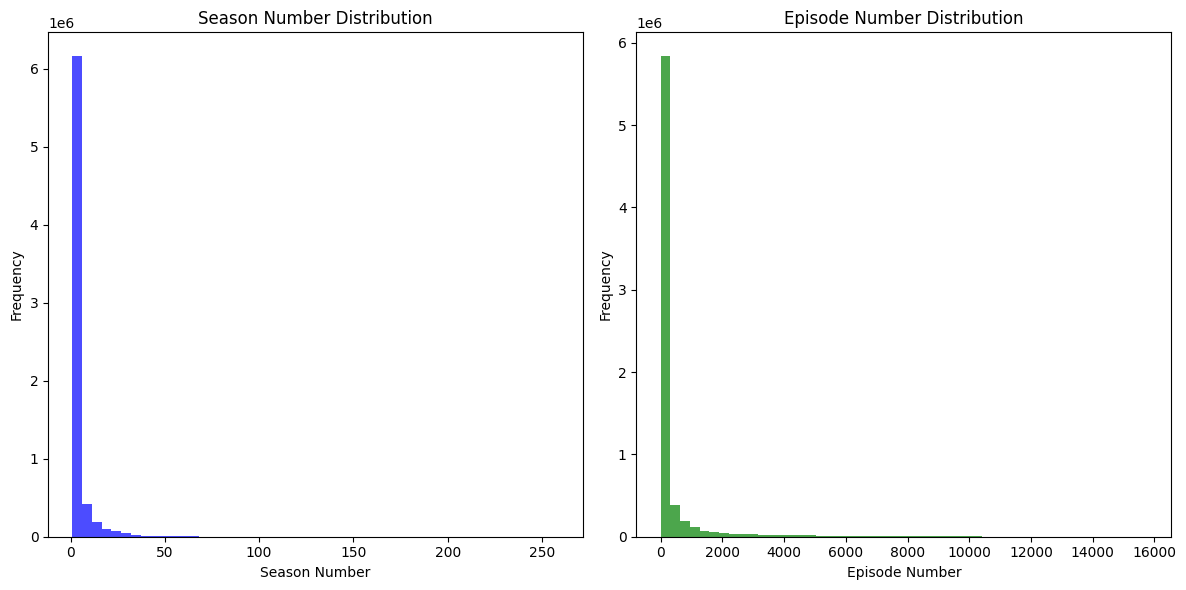

In [58]:
import matplotlib.pyplot as plt

season_data = df_cleaned.select("seasonNumber").toPandas()
episode_data = df_cleaned.select("episodeNumber").toPandas()

plt.figure(figsize=(12, 6))

# Plotting seasonNumber
plt.subplot(1, 2, 1)
plt.hist(season_data["seasonNumber"], bins=50, color='blue', alpha=0.7)
plt.title("Season Number Distribution")
plt.xlabel("Season Number")
plt.ylabel("Frequency")

# Plotting episodeNumber
plt.subplot(1, 2, 2)
plt.hist(episode_data["episodeNumber"], bins=50, color='green', alpha=0.7)
plt.title("Episode Number Distribution")
plt.xlabel("Episode Number")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [63]:
df_cleaned.coalesce(1).write \
    .option("delimiter", "\t") \
    .option("header", "true") \
    .csv("title.episode_cleaned.tsv")

In [64]:
testttttt = spark.read.csv("/content/title.episode_cleaned.tsv", sep="\t", header=True, inferSchema=True)
testttttt.show()


+---------+------------+------------+-------------+
|   tconst|parentTconst|seasonNumber|episodeNumber|
+---------+------------+------------+-------------+
|tt0041951|   tt0041038|           1|            9|
|tt0042816|   tt0989125|           1|           17|
|tt0043426|   tt0040051|           3|           42|
|tt0043631|   tt0989125|           2|           16|
|tt0043693|   tt0989125|           2|            8|
|tt0043710|   tt0989125|           3|            3|
|tt0044093|   tt0959862|           1|            6|
|tt0044668|   tt0044243|           2|           16|
|tt0044901|   tt0989125|           3|           46|
|tt0045519|   tt0989125|           4|           11|
|tt0045960|   tt0044284|           2|            3|
|tt0046135|   tt0989125|           4|            5|
|tt0046855|   tt0046643|           1|            4|
|tt0046864|   tt0989125|           5|           20|
|tt0047810|   tt0914702|           3|           36|
|tt0047852|   tt0047745|           1|           15|
|tt0047858| 